In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
plt.rcParams.update({'figure.facecolor':'white'})

from IPython.display import display

# prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_squared_error as MSE

## Import train and test data

In [4]:
# import train data and format timestamp column
df = pd.read_csv('../data/cleaned_sensors_dwd_train.csv', index_col=0)
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
# import test data and format timestamp column
df_test = pd.read_csv('../data/cleaned_sensors_dwd_test.csv', index_col=0)
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

## Choose location to be predcited

In [6]:
# looking for most complete location
df.groupby(['location_id'], dropna=False).PM2p5.count().sort_values()

location_id
79      6849
94      6952
27      9377
44     11246
121    11289
       ...  
12     17272
97     17295
99     17310
33     17325
98     17335
Name: PM2p5, Length: 66, dtype: int64

In [61]:
# choose the following location:
location = 99
print(f'location {location} has', round(df.query(f'location_id=={location}').PM2p5.count() / df.query(f'location_id=={location}').shape[0] * 100,1), '% of possible data')
display(df.query(f'location_id=={location}').describe().T)
display(df.query(f'location_id=={location}').loc[824567:824568,['location_id', 'city', 'lat', 'lon']])

location 99 has 98.7 % of possible data


,count,mean,std,min,25%,50%,75%,max
location_id,17544.0,99.000000,0.000000e+00,99.000000,99.000000,99.000000,99.000000,99.000000
lat,17544.0,50.150000,1.421126e-14,50.150000,50.150000,50.150000,50.150000,50.150000
lon,17544.0,8.756000,0.000000e+00,8.756000,8.756000,8.756000,8.756000,8.756000
PM10,17308.0,9.672618,9.720699e+00,0.454545,4.068643,6.827667,12.016500,520.497333
PM10_std,17308.0,2.168959,2.546731e+00,0.062829,1.304838,1.843611,2.537677,176.132881
PM2p5,17310.0,5.661162,5.352956e+00,0.436364,2.137333,4.001333,7.717833,302.430000
PM2p5_std,17308.0,0.596921,1.132372e+00,0.000000,0.264050,0.421781,0.687514,85.582232
humidity_sensors,4585.0,74.699963,2.048940e+01,21.606667,58.120000,78.373333,93.693333,99.900000
humidity_std,16596.0,0.542705,1.365268e+00,0.000000,0.000000,0.000000,0.498790,18.168366
pressure_sensors,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,location_id,city,lat,lon


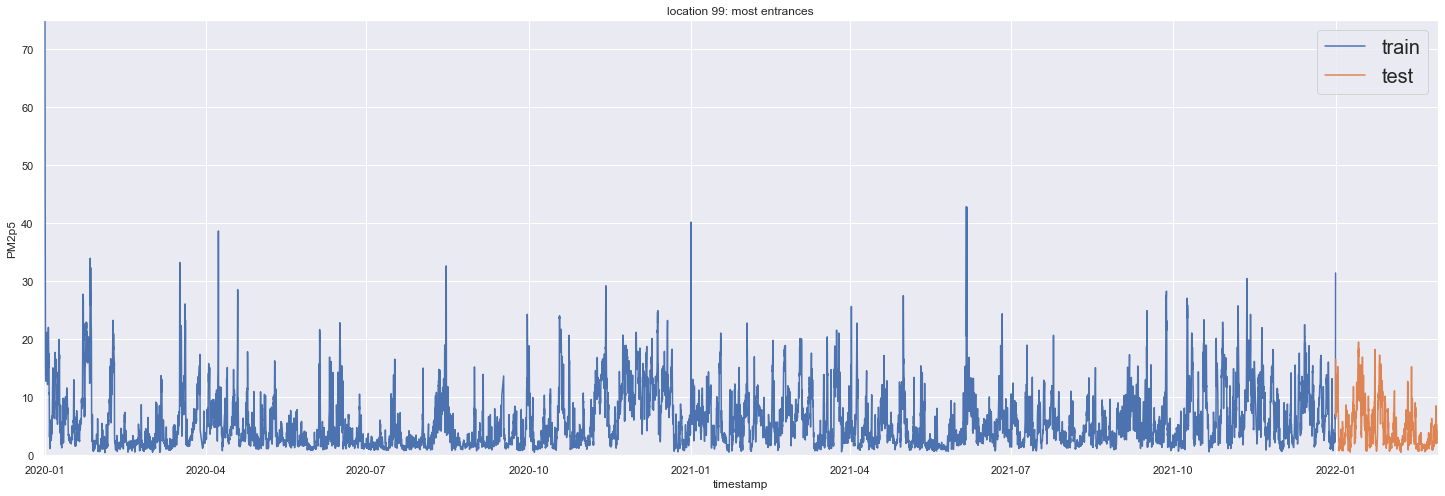

In [62]:
plt.figure(figsize=(25, 8))
plt.title(f'location {location}: most entrances')
sns.lineplot(data=df.query(f'location_id=={location}'), x='timestamp', y='PM2p5')
sns.lineplot(data=df_test.query(f'location_id=={location}'), x='timestamp', y='PM2p5')
plt.ylim(0,75)
plt.xlim(pd.to_datetime('2019-12-31'), pd.to_datetime('2022-02-28'))
plt.legend(['train', 'test'], fontsize=20)

## Prophet
### Train model
Trying model with (_reg) and without regressors.

In [63]:
# dictionary for comparison of results
models = {}
forecasts = {}


<AxesSubplot:xlabel='timestamp'>

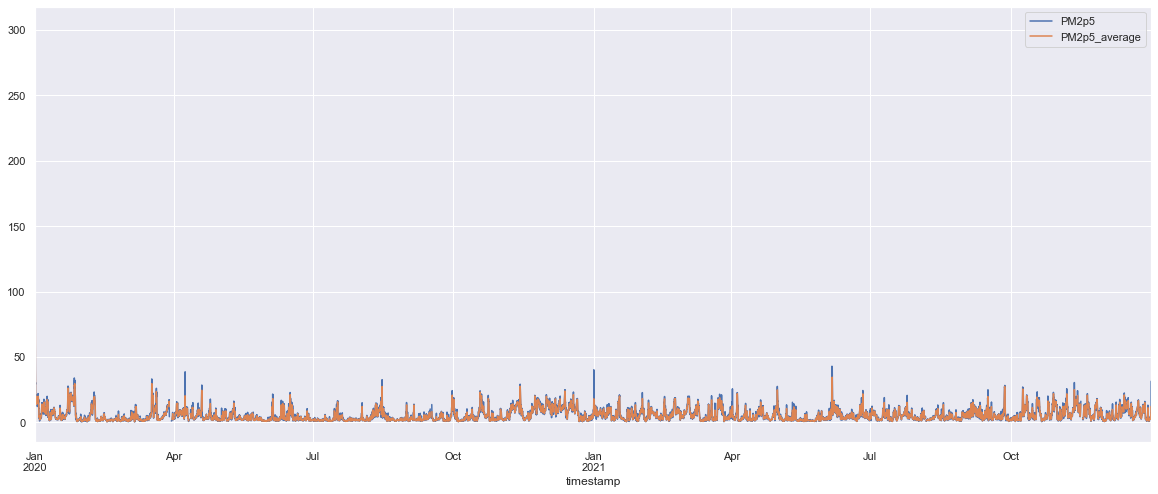

In [65]:
# calculate moving average of training data for cap and floor determination
df_average = df.query(f'location_id == {location}')[['timestamp','PM2p5']]
df_average['PM2p5_average'] = (df_average.PM2p5.shift(2) + df_average.PM2p5.shift(1) + df_average.PM2p5 + df_average.PM2p5.shift(-1) + df_average.PM2p5.shift(-2)) / 5

df_average.plot(x='timestamp', figsize=(20,8))
#plt.ylim(0,(df_average.PM2p5_average.max())


> Average calculation has flattened the curve, but Silvester peak remains. For this we'll take quantile(0.99) as PM2p5 cap.
> For PM2p5 floor we'll take the minimum of the moving average

In [66]:
# reduce data to one location
df_prophet = df.query(f'location_id == {location}')[['timestamp','PM2p5']]
df_prophet_reg = df.query(f'location_id == {location}')[['timestamp','PM2p5', 'humidity_dwd', 'temperature_dwd', 'pressure_dwd', 'wind_speed', 'precip']] 

# rename columns to expected format for prophet
df_prophet.rename(columns={'timestamp': 'ds', 'PM2p5': 'y'}, inplace=True)
df_prophet_reg.rename(columns={'timestamp': 'ds', 'PM2p5': 'y', 'humidity_dwd': 'humi', 'temperature_dwd': 'temp', 'pressure_dwd': 'press', 'wind_speed': 'windsp', 'precip': 'precip'}, inplace=True)

# prophet can not handle nans in dataframe
df_prophet.dropna(inplace=True)
df_prophet_reg.dropna(inplace=True)

# add cap column for to set growth = logistic
cap = df_average.PM2p5_average.quantile(0.99)
floor = df_average.PM2p5_average.min()
df_prophet['cap'] = cap 
df_prophet_reg['cap'] =  cap 
df_prophet['floor'] = floor 
df_prophet_reg['floor'] = floor


In [67]:
display(df_prophet)
display(df_prophet_reg)


,ds,y,cap,floor
842112,2020-01-01 00:00:00,302.430000,20.610312,0.5756
842113,2020-01-01 01:00:00,108.925333,20.610312,0.5756
842114,2020-01-01 02:00:00,75.406000,20.610312,0.5756
842115,2020-01-01 03:00:00,59.782857,20.610312,0.5756
842116,2020-01-01 04:00:00,45.314000,20.610312,0.5756
...,...,...,...,...
859651,2021-12-31 19:00:00,7.020667,20.610312,0.5756
859652,2021-12-31 20:00:00,6.633333,20.610312,0.5756
859653,2021-12-31 21:00:00,6.232667,20.610312,0.5756
859654,2021-12-31 22:00:00,9.489333,20.610312,0.5756


,ds,y,humi,temp,press,windsp,precip,cap,floor
842112,2020-01-01 00:00:00,302.430000,90.0,0.0,1023.1,2.7,0.0,20.610312,0.5756
842113,2020-01-01 01:00:00,108.925333,90.0,0.1,1022.9,2.8,0.0,20.610312,0.5756
842114,2020-01-01 02:00:00,75.406000,92.0,-1.1,1022.8,2.2,0.0,20.610312,0.5756
842115,2020-01-01 03:00:00,59.782857,93.0,-0.4,1022.3,1.6,0.0,20.610312,0.5756
842116,2020-01-01 04:00:00,45.314000,90.0,0.2,1022.1,2.0,0.0,20.610312,0.5756
...,...,...,...,...,...,...,...,...,...
859651,2021-12-31 19:00:00,7.020667,83.0,10.6,1011.2,2.6,0.0,20.610312,0.5756
859652,2021-12-31 20:00:00,6.633333,83.0,10.9,1011.9,3.5,0.0,20.610312,0.5756
859653,2021-12-31 21:00:00,6.232667,82.0,11.2,1012.2,3.3,0.0,20.610312,0.5756
859654,2021-12-31 22:00:00,9.489333,83.0,11.6,1012.3,3.0,0.0,20.610312,0.5756


In [68]:
# init Prophet model and fit it to train data
# without regressors

seasonality_mode='additive'
yearly_seasonality=True
weekly_seasonality=True
daily_seasonality=True
growth='logistic'
n_changepoints=20


model = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality, daily_seasonality=daily_seasonality,
        growth=growth,n_changepoints=n_changepoints)
model.fit(df_prophet);

# with regressors
model_reg = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality, daily_seasonality=daily_seasonality,
        growth=growth,n_changepoints=n_changepoints)
model_reg.add_regressor('temp', standardize=True, prior_scale=1)
model_reg.add_regressor('humi', standardize=True, prior_scale=1)
model_reg.add_regressor('press', standardize=True, prior_scale=1)
model_reg.add_regressor('windsp', standardize=True, prior_scale=1)
model_reg.add_regressor('precip', standardize=True, prior_scale=1)
model_reg.fit(df_prophet_reg)


Initial log joint probability = -24.5396
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       61175.5      0.261231        116366           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       62326.8    0.00697079       4481.77           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       62334.4   5.05671e-06       77.9707   7.004e-08       0.001      384  LS failed, Hessian reset 
     299       62339.5    6.7285e-05       122.716   3.143e-08       0.001      475  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       62342.7   4.43763e-05       286.663   3.159e-08       0.001      610  LS failed, Hessian reset 
     399       62343.8    0.00639787       1178.04           1           1      640 

Initial log joint probability = -24.3312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       60868.4     0.0675336       34312.2           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       62398.8    0.00123091       8533.41           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       62672.2   5.11648e-05       808.736           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       62726.2     0.0099585       6436.18           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       62756.4    0.00177169       3250.72       0.894       0.894      540   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [69]:
# save model
without_reg = '9'
with_reg = '10'
models[without_reg] = model
models[with_reg] = model_reg

### Predict

In [70]:
def create_regressor_column(ds, train_col, test_col, location_id):
    """Get a regressor of train or test data for corresponding timestamp

    Args:
        ds (datetime): timestamp
        train_col (string): column name of regressor in train data
        test_col (string): column name of regressor in test data

    Returns:
        float: regressor value for given timestamp
    """
    
    if ds in df_prophet_reg['ds'].values:
        return df_prophet_reg[df_prophet_reg['ds'] == ds][train_col].values[0]
    elif ds in df_test['timestamp'].values:
        return df_test[(df_test['timestamp'] == ds) & (df_test['location_id'] == location_id)][test_col].values[0]
    else:
        return np.nan
   

In [71]:
# without regressors: create dataframe for predictions of 10 days and predict 
future = model.make_future_dataframe(periods=240, freq='H')
future['cap'] = cap
future['floor'] = floor
forecast = model.predict(future)

# with regressors: create dataframe for predictions of 10 days 
future_reg = model.make_future_dataframe(periods=240, freq='H')
future_reg['temp'] = future_reg['ds'].apply(create_regressor_column, args=('temp', 'temperature_dwd', location))
future_reg['humi'] = future_reg['ds'].apply(create_regressor_column, args=('humi', 'humidity_dwd', location))
future_reg['press'] = future_reg['ds'].apply(create_regressor_column, args=('press', 'pressure_dwd', location))
future_reg['windsp'] = future_reg['ds'].apply(create_regressor_column, args=('windsp', 'wind_speed', location))
future_reg['precip'] = future_reg['ds'].apply(create_regressor_column, args=('precip', 'precip', location))

future_reg['cap'] = cap
future_reg['floor'] = floor

# consider autocorrelation: shift PM values by 1 hour
#future_reg['y_1'] = future_reg['ds'].apply(create_regressor_column, args=('y', 'PM2p5', location)).shift(1)
#future_reg['y_1'][0] = 0
    # drop nans
future_reg.dropna(inplace=True)
    # predict
forecast_reg = model_reg.predict(future_reg)

In [72]:
# save forecast
forecasts[without_reg] = forecast
forecasts[with_reg] = forecast_reg
forecasts.keys

<function dict.keys>

(18992.0, 19003.0)

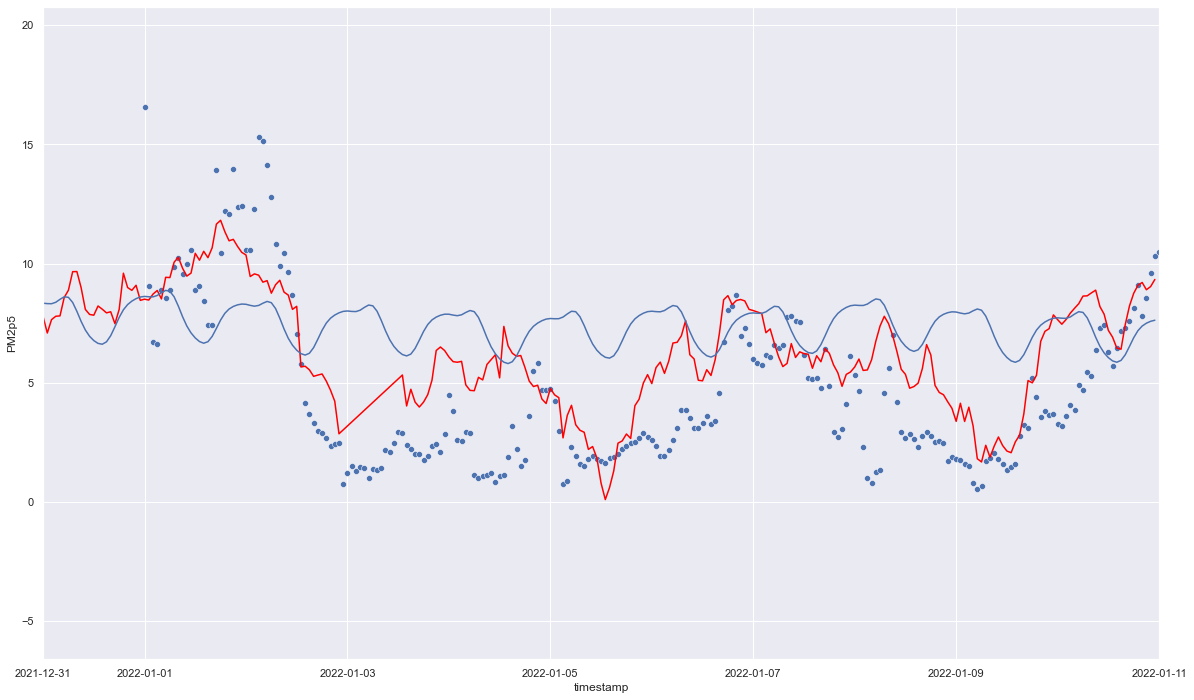

In [73]:
plt.figure(figsize=(20,12))
sns.scatterplot(df_test.query(f'location_id == {location}')['timestamp'], df_test.query(f'location_id == {location}')['PM2p5'])
#sns.lineplot(forecasts['1'].ds, forecasts['1'].yhat)
sns.lineplot(forecasts[with_reg].ds, forecasts[with_reg].yhat, color='red')
#sns.scatterplot(forecasts['2'].ds, forecasts['2'].yhat, collr='red)
sns.lineplot(forecasts[without_reg].ds, forecasts[without_reg].yhat)

plt.xlim(pd.to_datetime('2021-12-31'), pd.to_datetime('2022-01-11'))

### Show results

In [74]:
def plot_model_with_future(model, forecast, future, file, range_train):
    """plot the measured PM values together with forecast

    Args:
        model (_type_): _description_
        forecast (_type_): _description_
        future (_type_): _description_
        file (_type_): _description_
        range_train (_type_): _description_
    """
    fig = model.plot(forecast, ylabel='Value', figsize=(15, 8)) #xlabel='Date', 
    ax = fig.gca()
    sns.scatterplot(data=future, x='timestamp', y='PM2p5', ax=ax, color='green')
    #ax.set_title("Title", size=34)
    ax.set_xlabel("", size=34)
    ax.set_ylabel("PM 2.5 in µg/m³", size=34)
    ax.tick_params(axis="x", labelsize=24, rotation=90)
    ax.tick_params(axis="y", labelsize=24)
    
    ax.set_ylim(0, np.max(forecast.yhat) * 3) # set y-axis to 3 * max(yhat)
    ax.set_xlim(min(future.timestamp)- pd.Timedelta(days=range_train), min(future.timestamp) + pd.Timedelta(days=10)) # set x axis until test range and within range_train

    fig.savefig(file, bbox_inches='tight', facecolor="#EEEEEE")

    plt.show()

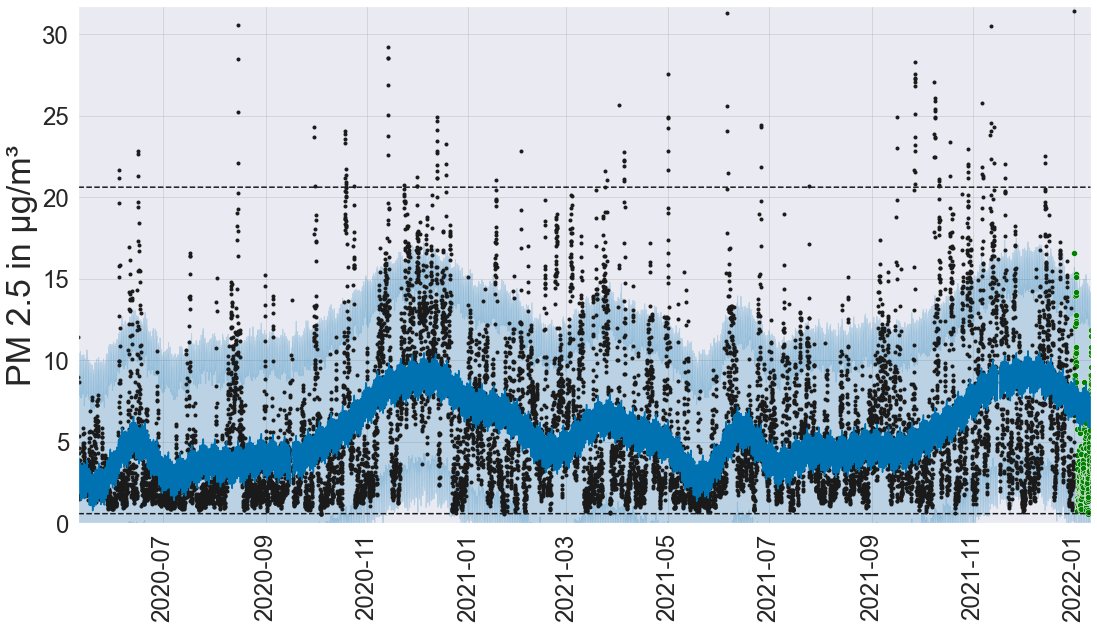

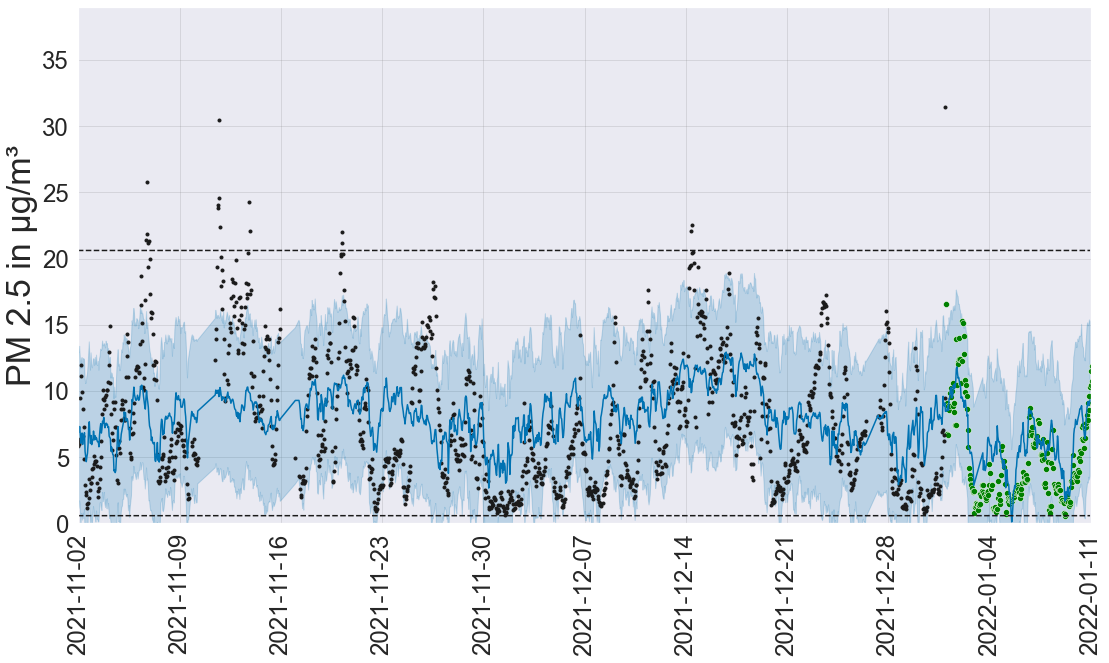

In [75]:
# plot
plot_model_with_future(model, forecast, df_test.query(f'location_id == {location}'), f'../images/prophet_location_id_{location}.png', 600)
plot_model_with_future(model_reg, forecast_reg, df_test.query(f'location_id == {location}'), f'../images/prophet_location_id_{location}.png', 60)


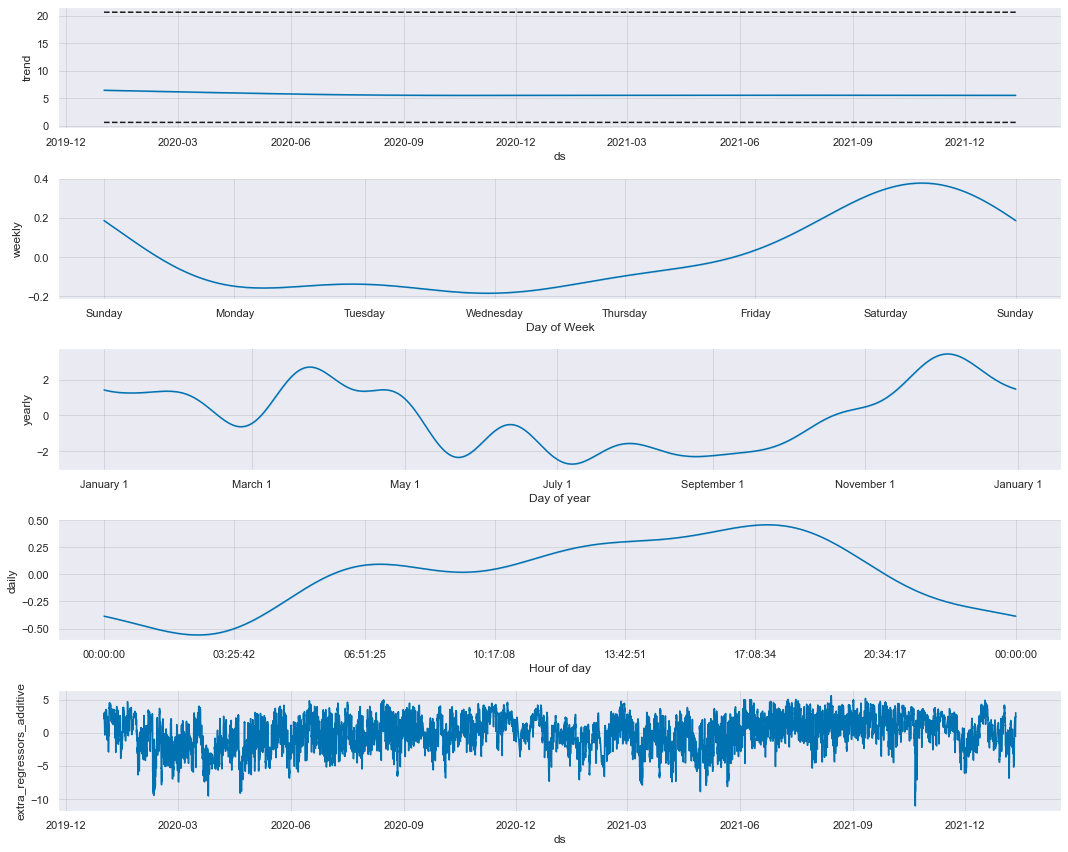

In [76]:
# plot components of models
fig = model_reg.plot_components(forecast_reg, figsize=(15, 12))
fig.savefig(f'../images/prophet_location_id_{location}_components.png', bbox_inches='tight', facecolor="#EEEEEE")

In [77]:
models.keys()

dict_keys(['9', '10'])

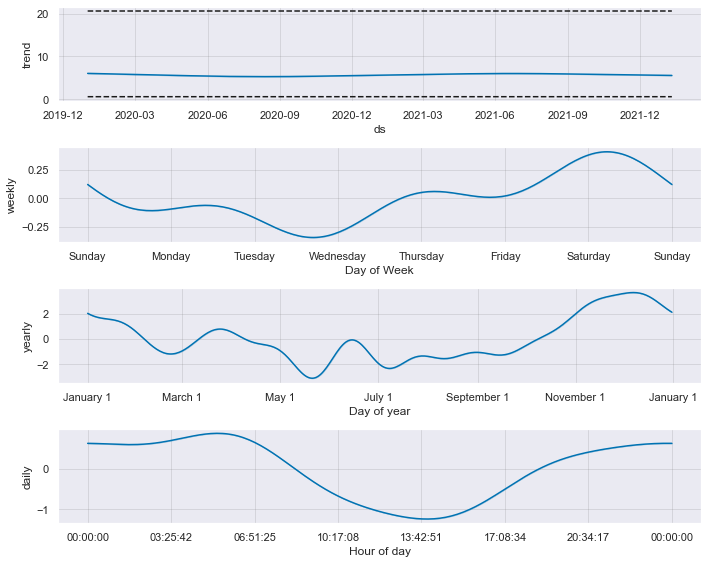

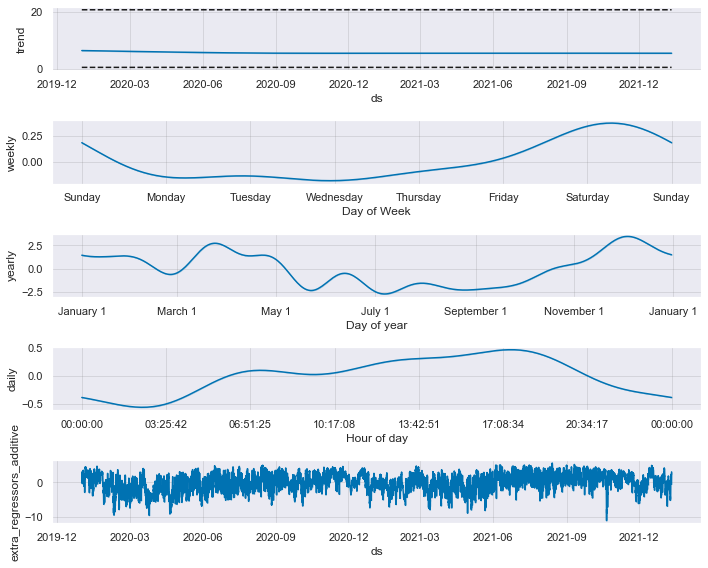

In [78]:
# plot components of models
#plt.figure(figsize=(20,15))
#plt.subplot(1,2,1)
fig = models[without_reg].plot_components(forecasts[without_reg], figsize=(10, 8))
#plt.subplot(1,2,2)
fig2 = models[with_reg].plot_components(forecasts[with_reg], figsize=(10, 8))

### Evaluate results
Calculate root mean squared error (RMSE)

In [79]:
# limit columns of test data for calculating rmse
df_rmse_test = df_test.query(f"location_id == {location} and timestamp <= '{max(forecast.ds)}'")[['timestamp','PM2p5']]
df_rmse_test_reg = df_test.query(f"location_id == {location} and timestamp <= '{max(forecast_reg.ds)}'")[['timestamp','PM2p5']]
# use train data for calculating RMSE
df_rmse_train = df.query(f"location_id == {location} ")[['timestamp','PM2p5']]
df_rmse_train_reg = df.query(f"location_id == {location}")[['timestamp','PM2p5']]

# merge forecast to test data
df_rmse_test =     df_rmse_test.merge(forecast[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
df_rmse_test_reg = df_rmse_test_reg.merge(forecast_reg[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
df_rmse_train =      df_rmse_train.merge(forecast[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
df_rmse_train_reg =  df_rmse_train_reg.merge(forecast_reg[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)

# drop NaN
df_rmse_test.dropna(inplace=True)
df_rmse_test_reg.dropna(inplace=True)
df_rmse_train.dropna(inplace=True)
df_rmse_train_reg.dropna(inplace=True)

# calculate rmse for specific time span
rmse = MSE(df_rmse_test['PM2p5'], df_rmse_test['yhat'], squared=False)
rmse_reg = MSE(df_rmse_test_reg['PM2p5'], df_rmse_test_reg['yhat'], squared=False)
rmse_train = MSE(df_rmse_train['PM2p5'], df_rmse_train['yhat'], squared=False)
rmse_train_reg = MSE(df_rmse_train_reg['PM2p5'], df_rmse_train_reg['yhat'], squared=False)

# show result
print(f'RMSE test for location {location} = {round(rmse,2)} µg/m3')
print(f'RMSE train for location {location} = {round(rmse_train,2)} µg/m3')

print(f'RMSE test for location {location} with regressors = {round(rmse_reg,2)} µg/m3')
print(f'RMSE train for location {location} with regressors = {round(rmse_train_reg,2)} µg/m3')


RMSE test for location 99 = 4.28 µg/m3
RMSE train for location 99 = 4.98 µg/m3
RMSE test for location 99 with regressors = 2.48 µg/m3
RMSE train for location 99 with regressors = 4.59 µg/m3


### Cross validation

In [80]:
df_cv = cross_validation(model_reg, 
                         horizon="10 days",
                         period="116.25 days", # every quarter of a year
                         initial="365 days", # a year
                         parallel=None
                        )

INFO:prophet:Making 4 forecasts with cutoffs between 2021-01-07 05:00:00 and 2021-12-21 23:00:00
  0%|          | 0/4 [00:00<?, ?it/s]

Initial log joint probability = -11.5115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       31076.5    0.00998963       4734.94           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         31107    0.00149624       1013.62      0.4683           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       31112.5    0.00359635       1199.32           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       31115.9   0.000306006       455.364           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       31117.4    0.00033185       243.427      0.9417      0.9417      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

 25%|██▌       | 1/4 [00:16<00:50, 16.73s/it]

Initial log joint probability = -12.0914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       39057.7     0.0016262       2131.57           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       41145.6    0.00043861       2533.05           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       41221.9    0.00198282       6315.64           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       41241.7   0.000220393       398.546           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       41244.7   0.000217712       410.785           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

 50%|█████     | 2/4 [00:38<00:38, 19.50s/it]

Initial log joint probability = -13.2691
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       48976.2    0.00808426       8355.57           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       52095.9    4.9215e-05       1229.09      0.7692      0.7692      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       52114.7    0.00253827       3282.08           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       52131.2   0.000217526       1731.61           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       52136.3   0.000253335       806.551      0.8824      0.8824      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

 75%|███████▌  | 3/4 [00:59<00:20, 20.56s/it]

Initial log joint probability = -17.6456
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       61450.8    0.00652765         11737           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       61802.3    0.00125788       3099.03           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       61843.6     0.0233587         14997      0.4895           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       61914.4   0.000650038       591.021           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       61916.2    0.00020874       338.412           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

100%|██████████| 4/4 [01:13<00:00, 18.41s/it]


In [81]:
#df_p = performance_metrics(df_cv, rolling_window=1)
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-07 06:00:00,1.989096,-3.960408,8.807878,8.665333,2021-01-07 05:00:00
1,2021-01-07 07:00:00,1.967308,-3.906477,8.366546,11.140714,2021-01-07 05:00:00
2,2021-01-07 08:00:00,2.132572,-4.205105,8.951585,11.602000,2021-01-07 05:00:00
3,2021-01-07 09:00:00,1.941686,-4.003901,8.183904,10.741333,2021-01-07 05:00:00
4,2021-01-07 10:00:00,1.695155,-4.652464,8.397891,9.728000,2021-01-07 05:00:00
...,...,...,...,...,...,...
934,2021-12-31 19:00:00,9.637898,4.066310,15.266845,7.020667,2021-12-21 23:00:00
935,2021-12-31 20:00:00,9.047365,2.770990,14.991632,6.633333,2021-12-21 23:00:00
936,2021-12-31 21:00:00,8.932734,3.090537,14.472521,6.232667,2021-12-21 23:00:00
937,2021-12-31 22:00:00,9.141191,3.342902,14.946889,9.489333,2021-12-21 23:00:00


In [88]:
df_pm = performance_metrics(df_cv, rolling_window=0)
df_pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 01:00:00,12.568081,3.545149,2.532334,0.464745,0.496173,0.520758,1.00
1,0 days 02:00:00,22.282727,4.720458,3.128683,0.478684,0.491410,0.563648,0.75
2,0 days 03:00:00,24.988382,4.998838,3.665388,0.715522,0.596852,0.730259,0.75
3,0 days 04:00:00,21.728332,4.661366,3.438937,0.769808,0.573561,0.734691,0.75
4,0 days 05:00:00,19.128887,4.373658,3.447822,0.810164,0.667153,0.816246,0.75
...,...,...,...,...,...,...,...,...
235,9 days 20:00:00,63.609330,7.975546,5.941426,0.553582,0.450856,0.827055,0.75
236,9 days 21:00:00,52.565330,7.250195,4.978320,0.483074,0.469404,0.740851,0.75
237,9 days 22:00:00,49.684743,7.048741,5.086288,0.520997,0.539310,0.787384,0.75
238,9 days 23:00:00,59.871981,7.737699,5.184758,0.557377,0.619697,0.792390,0.75


<AxesSubplot:xlabel='horizon'>

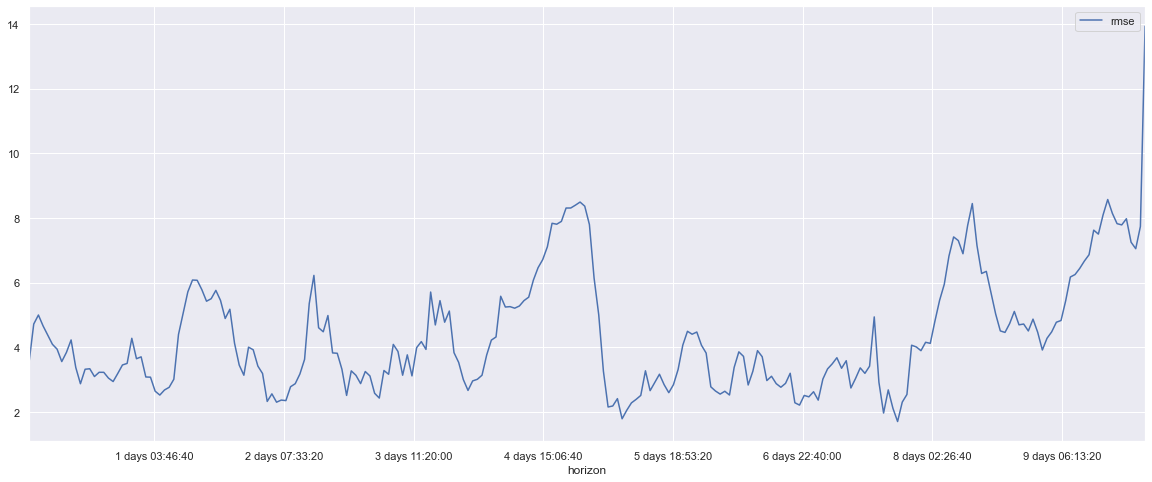

In [89]:
df_pm.plot(x='horizon', y='rmse', figsize=(20,8))
#plt.xticks(range=(1,10,1))
#plt.xticks(np.arange(df_pm['horizon'].min(), df_pm['horizon'].max(), 1));